# Initialize

In [1]:
from ops.imports_ipython import *
import glob

In [2]:
os.chdir('20200202_6W-LaC024E/')

# combine tables

In [4]:
ops.utils.combine_tables('cp_phenotype',output_filetype='hdf',subdir='process_ph/tables',n_jobs=-2,
    usecols=[
        'well','tile','cell',
        'i','j','bounds_0','bounds_1','bounds_2','bounds_3',
        # to identify cells on an acquisition border
        'cell_dapi_min','cell_tubulin_min','cell_gh2ax_min','cell_phalloidin_min'
        ]
)
os.rename('cp_phenotype.hdf','min_cp_phenotype.hdf')

In [5]:
ops.utils.combine_tables('merge',output_filetype='hdf',subdir='alignment',n_jobs=-2)

In [6]:
ops.utils.combine_tables('cells',output_filetype='hdf',subdir='process_sbs/tables',n_jobs=-2)

In [7]:
df_merged = pd.read_hdf('merge.hdf')

# add distance to FOV center for each cell

In [8]:
def fov_distance(df,i='i',j='j',dimensions=(2960,2960),suffix=''):
    distance  = lambda x: np.sqrt((x[i]-(dimensions[0]/2))**2+(x[j]-(dimensions[1]/2))**2)
    df['fov_distance'+suffix]=df.apply(distance,axis=1)
    return df

In [9]:
df_merged.pipe(fov_distance,i='i_0',j='j_0',suffix='_0');

In [10]:
df_merged.pipe(fov_distance,i='i_1',j='j_1',dimensions=(1480,1480),suffix='_1');

In [11]:
df_merged.sort_values(['fov_distance_1']).head()

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1
794,A3,1252,822,1544.061622,1455.355676,323,2915,740.214876,739.884298,0.226348,68.638430,0.244047
714,A2,1279,741,1543.246706,1452.357247,331,2327,739.707865,739.988764,0.134083,69.023674,0.292351
727,A3,789,760,1517.533711,1483.503116,201,2904,740.468468,740.153153,0.138697,37.696834,0.492868
540,B2,724,569,1509.327798,1451.590614,186,2191,739.420000,739.630000,0.137727,40.831519,0.687968
586,A1,28,624,1444.109780,1482.149701,9,2433,739.934066,740.736264,0.380540,35.954542,0.739210


# add mapping info

In [12]:
df_cells = pd.read_hdf('cells.hdf')

In [13]:
df_cells.head()

,cell,tile,well,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,...,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,barcode_count,sgRNA_0,gene_symbol_0,group_0,sgRNA_1,gene_symbol_1,group_1
0,17,166,B3,0.597111,0.530263,0.484143,0.658835,0.321963,0.141298,0.429827,...,1,NaN,0.0,1,GAGGTATCATAATTCCCAGG,ATP6V1A,essentials_11L2,NaN,NaN,NaN
1,19,166,B3,0.827440,0.217931,0.314575,0.264544,0.704295,0.647835,0.259778,...,1,CCCCACCCACA,1.0,2,GCCAAGATCGTGAAGCCCAA,RPS7,essentials_11L2,NaN,NaN,NaN
2,24,166,B3,1.000000,0.400528,0.741337,0.476006,0.922510,0.654988,0.067658,...,1,NaN,0.0,1,AAAGGATGATCACAATGTTC,RAB4A,essentials_11L2,NaN,NaN,NaN
3,27,166,B3,1.000000,0.939437,0.646268,0.608081,0.343315,1.000000,0.787477,...,2,NaN,0.0,2,AGCGTGGTAAGCGGCAGACG,TNNT1,essentials_11L2,NaN,NaN,NaN
4,28,166,B3,0.640094,0.615193,0.747011,0.744167,0.768473,0.156254,1.000000,...,1,NaN,0.0,1,CAATATCGGGTGCTACAGGA,nontargeting,essentials_11L2,NaN,NaN,NaN


In [14]:
df_cells['mapped_single_gene'] = (df_cells.apply(lambda x: True 
                    if (pd.notnull(x.gene_symbol_0)&pd.isnull(x.gene_symbol_1))|(x.gene_symbol_0==x.gene_symbol_1) 
                    else False,axis=1)
                                  )

In [15]:
df_cells.mapped_single_gene.value_counts()

True     4574148
False    2157553
Name: mapped_single_gene, dtype: int64

In [16]:
df_merged = df_merged.merge((df_cells[['well','tile','cell','sgRNA_0','gene_symbol_0','group_0','mapped_single_gene']]
                             .rename({'tile':'site','cell':'cell_1'},axis=1)),
                            how='left',on=['well','site','cell_1'])

In [17]:
df_merged.head(10).sort_values(['mapped_single_gene','fov_distance_1'],ascending=[False,True])

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,group_0,mapped_single_gene
1,B3,474,451,1092.389009,1080.368239,123,2,4.359649,639.008772,0.693279,556.729580,742.540204,NaN,NaN,NaN,NaN
2,B3,474,447,1082.052570,1840.820093,123,4,2.456140,830.526316,1.567729,537.171571,743.078703,NaN,NaN,NaN,NaN
7,B3,474,454,1104.946878,905.460022,123,18,6.252252,594.612613,1.186161,686.120274,748.012867,NaN,NaN,NaN,NaN
6,B3,474,453,1102.045556,838.778193,123,16,5.363636,577.597403,1.545607,744.321817,752.373039,NaN,NaN,NaN,NaN
5,B3,474,452,1098.433249,652.899874,123,15,4.934783,531.630435,0.825219,910.872002,764.027977,NaN,NaN,NaN,NaN
3,B3,474,450,1087.495982,2455.862227,123,6,2.756757,984.635135,1.028069,1051.839575,776.771491,NaN,NaN,NaN,NaN
9,B3,474,456,1106.642424,201.272727,123,21,6.400000,418.077778,1.596550,1332.118357,801.126006,NaN,NaN,NaN,NaN
0,B3,474,449,1084.429774,108.590742,123,1,2.475000,396.087500,0.663577,1427.318870,813.768354,NaN,NaN,NaN,NaN
8,B3,474,455,1108.107317,57.383972,123,20,6.580247,382.506173,1.438431,1470.421889,815.908310,NaN,NaN,NaN,NaN
4,B3,474,448,1082.717680,2892.225967,123,7,2.083333,1093.816667,1.270202,1467.043089,818.356426,NaN,NaN,NaN,NaN


# add phenotype min info

In [18]:
df_phenotype = pd.read_hdf('min_cp_phenotype.hdf').fillna(0)

In [19]:
min_cols = [col for col in df_phenotype.columns if '_min' in col]
info_cols = [col for col in df_phenotype.columns if col not in min_cols]

In [21]:
df_phenotype['channels_min'] = df_phenotype[min_cols].apply(lambda x: x.min(axis=0),axis=1)

In [23]:
df_merged = df_merged.merge((df_phenotype[['well','tile','cell','channels_min']]
                             .rename(columns={'cell':'cell_0'})),
                            how='left',on=['well','tile','cell_0'])

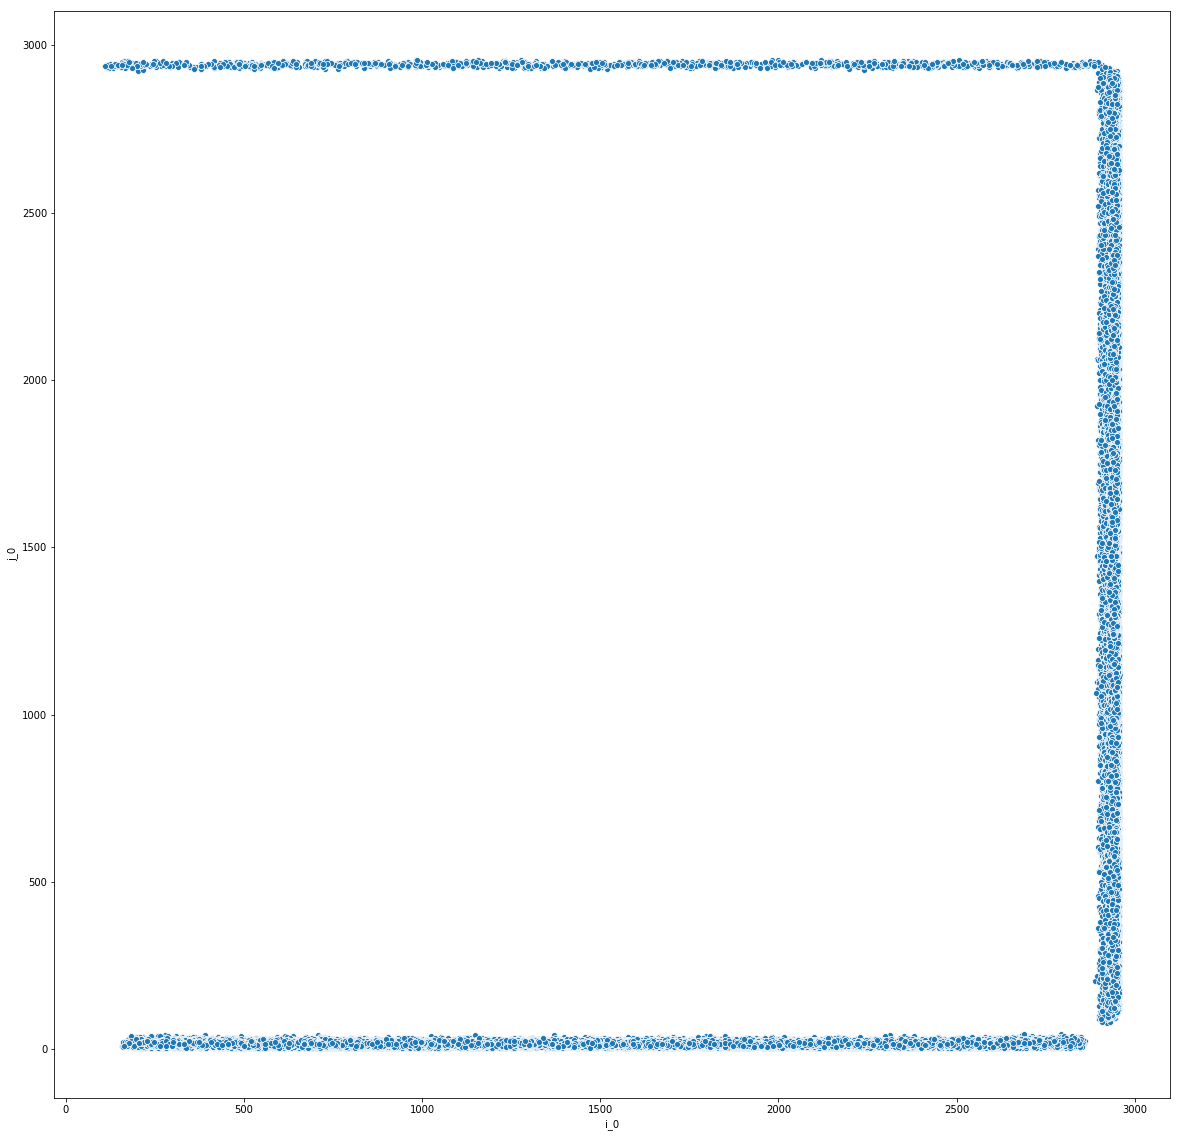

In [24]:
# visualize cells overlapping channel alignment edges
# (only relevant if phenotype channels are acquired separately)
plt.figure(figsize=(20,20))
sns.scatterplot(data=(df_merged
                      .query('channels_min==0')
                      [['i_0','j_0']]
                     ),
                x='i_0',y='j_0')

# filter merged datasets for duplicates

In [6]:
df_merged.groupby(['well','tile']).cell_0.value_counts().value_counts()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


1    6140418
2    1744412
3      27154
4       1248
Name: cell_0, dtype: int64

In [7]:
df_merged.groupby(['well','site']).cell_1.value_counts().value_counts()

1    5802131
2    1792765
3      68577
4      30576
Name: cell_1, dtype: int64

In [8]:
df_merged.drop_duplicates(['well','site','cell_1']).pipe(len)

7694049

In [10]:
df_merged.pipe(len)

9715696

In [11]:
# remove cells with phenotype channel min ==0
df_merged_ph = (df_merged
             .query('channels_min>0')
            )

In [12]:
df_merged_ph.drop_duplicates(['well','site','cell_1']).pipe(len)

7686283

In [13]:
df_merged_ph.groupby(['well','site']).cell_1.value_counts().value_counts()

1    5904821
2    1696669
3      58449
4      26344
Name: cell_1, dtype: int64

In [14]:
# drop sbs cells mapping to same phenotype cell by priority (mapping, fov_distance)
df_merged_filt = (df_merged_ph
                  .sort_values(['mapped_single_gene','fov_distance_1'],
                               ascending=[False,True])
                  .drop_duplicates(['well','tile','cell_0'],keep='first')
                 )

In [15]:
df_merged_filt.groupby(['well','site']).cell_1.value_counts().value_counts()

1    4577739
2    1464971
3      58449
4      26344
Name: cell_1, dtype: int64

In [16]:
# drop duplicated phenotype cells mapping to same sbs cell by priority (fov_distance)
df_merged_filt_filt = (df_merged_filt
                       .sort_values(['fov_distance_0'],ascending=True)
                       .drop_duplicates(['well','site','cell_1'],keep='first')
                      )

In [17]:
df_merged_filt_filt.pipe(len)

6127503

In [18]:
df_merged_filt_filt[df_merged_filt_filt.mapped_single_gene==True].pipe(len)

3480190

In [ ]:
df_merged.to_hdf('merge.hdf', 'x', mode='w')

In [ ]:
df_merged_filt_filt.to_hdf('merged_deduped.hdf', 'x', mode='w')

# check cell matching rate

In [22]:
df_merged_filt_filt.well.value_counts()

A2    1339136
B2    1323566
A1    1162905
B3    1154494
A3    1147402
Name: well, dtype: int64

In [24]:
df_sbs_info = pd.concat([pd.read_hdf(f) for f in glob.glob('sbs_info_*.hdf')])

In [25]:
df_sbs_info.to_hdf('sbs_info.hdf','x',mode='w')

In [26]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_1','tile':'site'}

#before deduping, how many sbs cells map to a phenotype cell
df_sbs_matching = (df_sbs_info
                   .rename(columns=cols_1)
                   .drop(columns=['i','j'])
                   .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','site','cell_1'])
                  )

In [27]:
# before deduping
for well,df in df_sbs_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 90.46666468202939%
For well A2, cell matching rate is 89.7668651005024%
For well A3, cell matching rate is 90.57752813088449%
For well B2, cell matching rate is 89.97890181787173%
For well B3, cell matching rate is 90.41833876611173%


In [28]:
del df_sbs_matching

In [29]:
del df_sbs_info

In [30]:
df_ph_info = pd.concat([pd.read_hdf(f) for f in glob.glob('ph_info_*.hdf')])

In [31]:
df_ph_info.to_hdf('ph_info.hdf','x',mode='w')

In [32]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_0'}

#before deduping, how many sbs cells map to a phenotype cell
df_ph_matching = (df_ph_info
                 .rename(columns=cols_1)
                 .drop(columns=['i','j'])
                 .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','tile','cell_0'])
                )

In [33]:
for well,df in df_ph_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 93.41447239786899%
For well A2, cell matching rate is 93.30460834146834%
For well A3, cell matching rate is 93.68255928815961%
For well B2, cell matching rate is 93.21950259695237%
For well B3, cell matching rate is 92.86182455295969%
